# Analyzing Orderbooks Before Large Returns - Squid Ink Round 2 (Part 1)

This notebook analyzes the state of the orderbook right before large changes in returns for Squid Ink in Round 2. The goal is to identify potential predictive patterns in the orderbook that might signal upcoming large price movements.

## Part 1: Load Data and Identify Large Return Events

In [1]:
# Import necessary libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Configure plots to be larger and more readable
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Try to import seaborn for better styling
try:
    import seaborn as sns
    sns.set(style="whitegrid")
    print("Using Seaborn for plot styling")
except ImportError:
    print("Seaborn not available, using matplotlib default styling")

Using Seaborn for plot styling


### 1.1 Define Function to Load Price Data

In [2]:
def load_price_data(round_num, product='SQUID_INK'):
    """
    Load price data for a specific round and product.
    
    Parameters:
        round_num (int): Round number
        product (str): Product name (default: 'SQUID_INK')
        
    Returns:
        pd.DataFrame: DataFrame containing price data
    """
    # Path to data directory - try multiple possible locations
    possible_data_paths = [
        '../../../Prosperity 3 Data',
        '../../../../Prosperity 3 Data',
        '../../../../../Prosperity 3 Data',
        'Prosperity 3 Data'
    ]
    
    # Find the first valid data path
    data_path = None
    for path in possible_data_paths:
        if os.path.exists(path):
            data_path = path
            print(f"Found data directory at {path}")
            break
    
    if data_path is None:
        print("Could not find data directory")
        return pd.DataFrame()
    
    # List all CSV files for the round
    import glob
    file_pattern = os.path.join(data_path, f'Round {round_num}/prices_round_{round_num}_day_*.csv')
    files = glob.glob(file_pattern)
    
    if not files:
        print(f"No files found matching pattern: {file_pattern}")
        return pd.DataFrame()
    
    # Load and concatenate all files
    dfs = []
    for file in files:
        print(f"Loading {file}...")
        df = pd.read_csv(file, sep=';')
        dfs.append(df)
    
    # Concatenate all dataframes
    all_data = pd.concat(dfs, ignore_index=True)
    
    # Filter for the specified product
    product_data = all_data[all_data['product'] == product].copy()
    print(f"Successfully loaded price data with {len(product_data)} rows")
    
    return product_data

### 1.2 Load Squid Ink Price Data

In [3]:
# Load Squid Ink price data for Round 2
squid_data = load_price_data(2, 'SQUID_INK')

# Display the first few rows
squid_data.head()

Found data directory at ../../../../Prosperity 3 Data
Loading ../../../../Prosperity 3 Data\Round 2\prices_round_2_day_-1.csv...
Loading ../../../../Prosperity 3 Data\Round 2\prices_round_2_day_0.csv...
Loading ../../../../Prosperity 3 Data\Round 2\prices_round_2_day_1.csv...
Successfully loaded price data with 30000 rows


,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
2,-1,0,SQUID_INK,2005,1,2002.0,31.0,NaN,NaN,2006,31,NaN,NaN,NaN,NaN,2005.5,0.0
15,-1,100,SQUID_INK,2004,24,NaN,NaN,NaN,NaN,2007,24,NaN,NaN,NaN,NaN,2005.5,0.0
21,-1,200,SQUID_INK,2003,22,NaN,NaN,NaN,NaN,2006,20,NaN,NaN,NaN,NaN,2004.5,0.0
25,-1,300,SQUID_INK,2003,31,NaN,NaN,NaN,NaN,2006,31,NaN,NaN,NaN,NaN,2004.5,0.0
34,-1,400,SQUID_INK,2004,27,NaN,NaN,NaN,NaN,2007,27,NaN,NaN,NaN,NaN,2005.5,0.0


In [4]:
# Check the columns in the dataframe
print("Columns in the price data:")
squid_data.columns

Columns in the price data:


Index(['day', 'timestamp', 'product', 'bid_price_1', 'bid_volume_1',
       'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3',
       'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2',
       'ask_price_3', 'ask_volume_3', 'mid_price', 'profit_and_loss'],
      dtype='object')

### 1.3 Calculate Returns and Identify Large Return Events

In [5]:
# Calculate mid price
squid_data['mid_price'] = (squid_data['ask_price_1'] + squid_data['bid_price_1']) / 2

# Sort by timestamp to ensure proper return calculation
squid_data = squid_data.sort_values('timestamp')

# Calculate returns
squid_data['returns'] = squid_data['mid_price'].pct_change()

# Calculate absolute returns
squid_data['abs_returns'] = squid_data['returns'].abs()

# Display summary statistics of returns
print("Summary statistics of returns:")
squid_data['returns'].describe()

Summary statistics of returns:


count    29999.000000
mean         0.000679
std          0.036895
min         -0.125756
25%         -0.027352
50%          0.003051
75%          0.024625
max          0.113577
Name: returns, dtype: float64

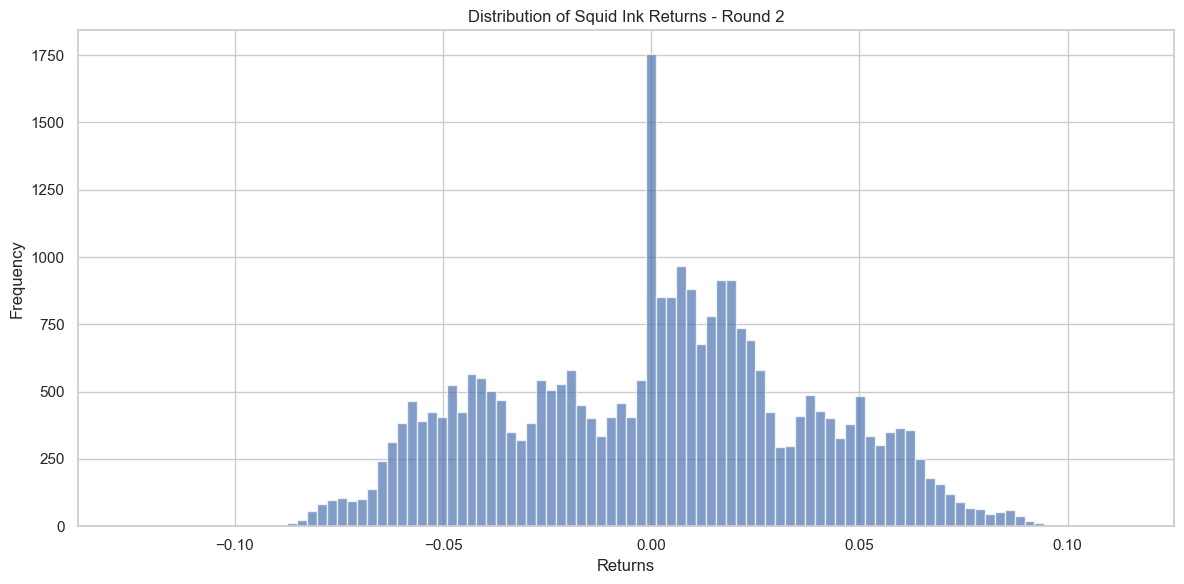

In [6]:
# Plot the distribution of returns
plt.figure(figsize=(12, 6))
plt.hist(squid_data['returns'].dropna(), bins=100, alpha=0.7)
plt.title('Distribution of Squid Ink Returns - Round 2')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# Define what constitutes a "large" return (e.g., top 1% of absolute returns)
large_return_threshold = squid_data['abs_returns'].quantile(0.99)
print(f"Large return threshold (99th percentile): {large_return_threshold:.6f}")

# Identify timestamps with large returns
large_return_indices = squid_data[squid_data['abs_returns'] >= large_return_threshold].index
large_return_timestamps = squid_data.loc[large_return_indices, 'timestamp']

print(f"Number of large return events: {len(large_return_timestamps)}")
print(f"Percentage of all observations: {len(large_return_timestamps) / len(squid_data) * 100:.2f}%")

Large return threshold (99th percentile): 0.080723
Number of large return events: 300
Percentage of all observations: 1.00%


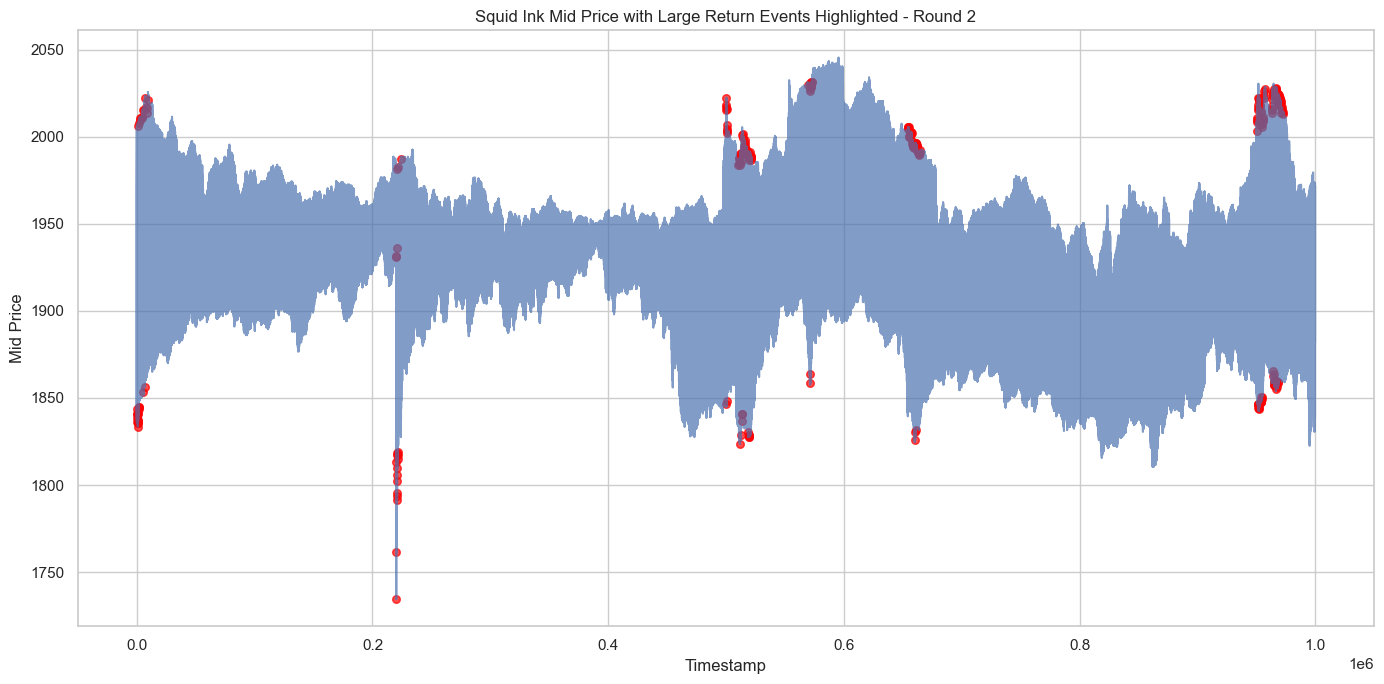

In [8]:
# Plot mid price and highlight large return events
plt.figure(figsize=(14, 7))
plt.plot(squid_data['timestamp'], squid_data['mid_price'], alpha=0.7)
plt.scatter(large_return_timestamps, 
            squid_data.loc[large_return_indices, 'mid_price'], 
            color='red', alpha=0.7, s=30)
plt.title('Squid Ink Mid Price with Large Return Events Highlighted - Round 2')
plt.xlabel('Timestamp')
plt.ylabel('Mid Price')
plt.grid(True)
plt.tight_layout()
plt.show()

### 1.4 Save Data for Next Part

Let's save the processed data so we can use it in the next part of the analysis.

In [9]:
# Create output directory if it doesn't exist
output_dir = '../data'
os.makedirs(output_dir, exist_ok=True)

# Save processed data
squid_data.to_pickle(os.path.join(output_dir, 'squid_data_with_returns.pkl'))
print(f"Saved processed data to {os.path.join(output_dir, 'squid_data_with_returns.pkl')}")

# Save large return indices
pd.Series(large_return_indices).to_pickle(os.path.join(output_dir, 'large_return_indices.pkl'))
print(f"Saved large return indices to {os.path.join(output_dir, 'large_return_indices.pkl')}")

Saved processed data to ../data\squid_data_with_returns.pkl
Saved large return indices to ../data\large_return_indices.pkl


## Summary of Part 1

In this first part of the analysis, we have:

1. Loaded the price data for Squid Ink in Round 2
2. Calculated mid prices and returns
3. Identified large return events (top 1% of absolute returns)
4. Visualized these events on the price chart
5. Saved the processed data for use in the next part

In Part 2, we will extract and analyze orderbook features right before these large return events.